In [79]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from torchinfo import summary
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [2]:
# Checking for Mac M1 GP
if torch.backends.mps.is_available():
    print("MPS is available.")
else:
    print("MPS is not available.")

MPS is available.


In [3]:
# Since MPS is available, we can use the following code to enable it.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Base class for Dataloading and splitting of the dataset

In [4]:
# Creatiing a class for CIFAR10 data loader (baseline model)
class CIFAR10DataLoader:
    def __init__(self, batch_size=64, validation_split=0.2, random_state=42, num_workers=2):
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.random_state = random_state
        self.num_workers = num_workers

        # Train Transformations
        self.train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        # Test Transformations
        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Load the full training dataset
        self.full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=self.train_transform)
        self.testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=self.test_transform)

        # Prepare datasets
        self.trainset, self.valset = self.split_train_validation()
        
        # Create data loaders
        self.trainloader = DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.valloader = DataLoader(self.valset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        self.testloader = DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def split_train_validation(self):
        # Extract labels for stratified split
        labels = self.full_trainset.targets
        
        # Split indices for training and validation sets
        train_indices, val_indices = train_test_split(
            range(len(self.full_trainset)),
            test_size=self.validation_split,
            stratify=labels,
            random_state=self.random_state
        )
        
        # Create train and validation subsets
        trainset = Subset(self.full_trainset, train_indices)
        valset = Subset(self.full_trainset, val_indices)
        
        return trainset, valset

    def get_loaders(self):
        return self.trainloader, self.valloader, self.testloader

# Usage for baseline model (no augmentation)
data_loader = CIFAR10DataLoader(batch_size=64)
trainloader, valloader, testloader = data_loader.get_loaders()


Files already downloaded and verified
Files already downloaded and verified


Unique classes in CIFAR-10 dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Unique classes in the dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


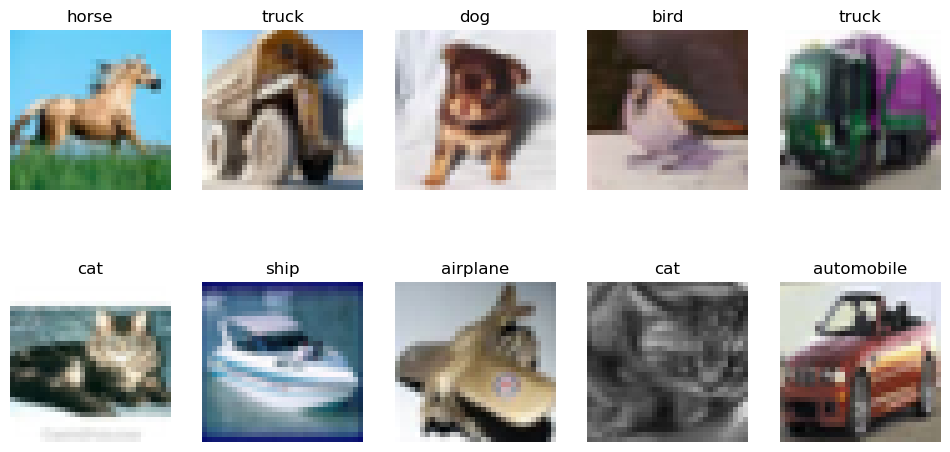

In [ ]:
# Get class names
class_names = data_loader.full_trainset.classes
print("Unique classes in CIFAR-10 dataset:", class_names)

# Function to display sample images from the dataset
def show_sample_images(loader, classes, num_samples=10):
    # Get a batch of images and labels
    dataiter = iter(loader)
    images, labels = next(dataiter)  
    
    # Create a grid of images
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        ax = plt.subplot(2, 5, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))  
        img = img * 0.5 + 0.5  
        plt.imshow(img)
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

# Display unique classes
print("Unique classes in the dataset:", class_names)

# Show sample images from the training set
show_sample_images(trainloader, class_names)

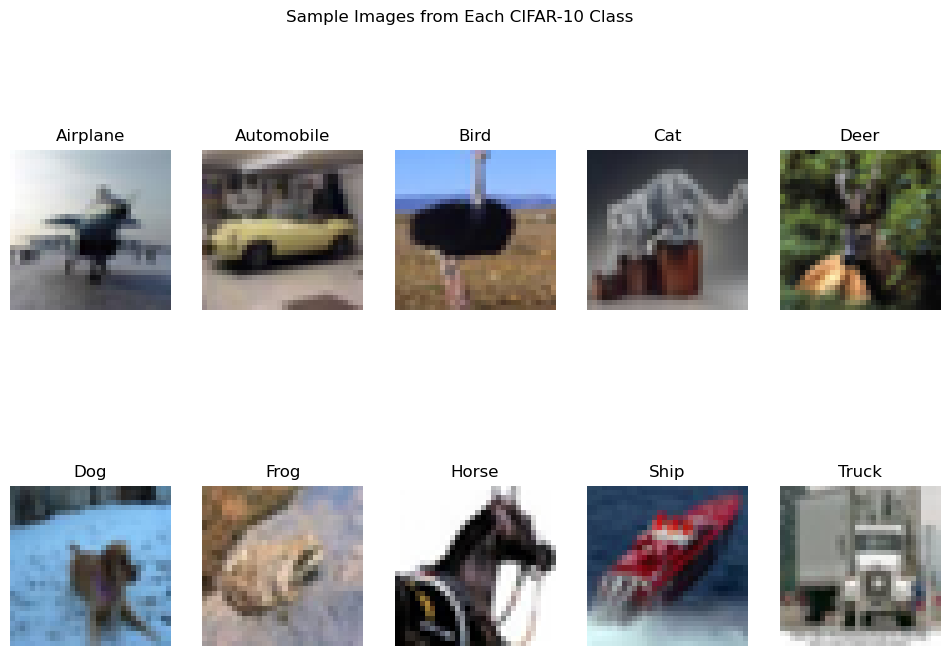

In [62]:
class_names = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

def show_class_samples(data_loader, class_names):
    # Dictionary to store one sample per class
    samples_per_class = {class_name: None for class_name in class_names}
    found_classes = set()

    # Iterate through the data loader to find samples for each class
    for images, labels in data_loader:
        for img, label in zip(images, labels):
            class_name = class_names[label]
            if samples_per_class[class_name] is None:
                samples_per_class[class_name] = img
                found_classes.add(class_name)
            # Stop if we have found a sample for each class
            if len(found_classes) == len(class_names):
                break
        if len(found_classes) == len(class_names):
            break

    # Plot the samples
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(class_names):
        plt.subplot(2, 5, i + 1)
        image = samples_per_class[class_name]
        image = image / 2 + 0.5  # Unnormalize the image
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        plt.title(class_name)
        plt.axis('off')
    plt.suptitle("Sample Images from Each CIFAR-10 Class")
    plt.show()

# Display samples
show_class_samples(trainloader, class_names)

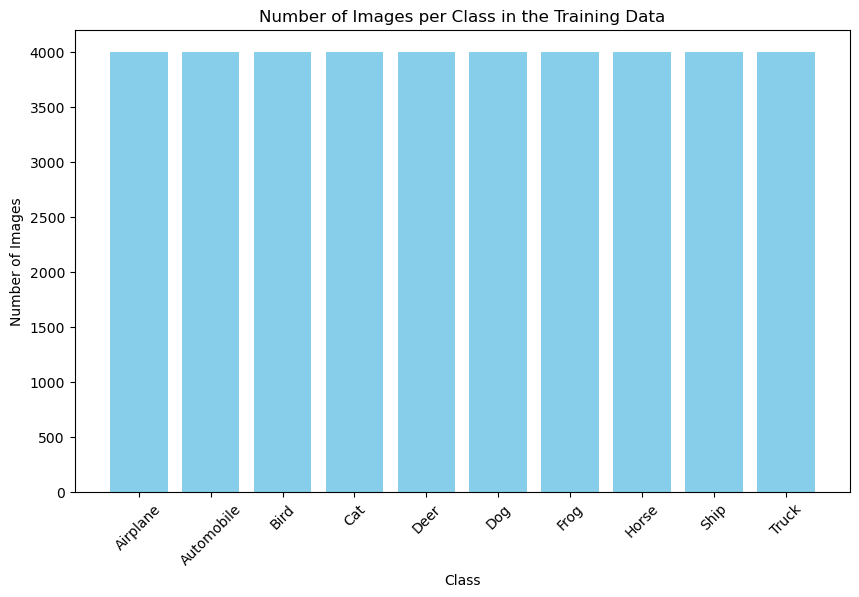

In [69]:
all_labels = [label for _, label in data_loader.trainset]

# Count occurrences of each class label
label_counts = Counter(all_labels)

# CIFAR-10 class names
class_names = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

# Map label counts to class names
label_counts_mapped = {class_names[label]: count for label, count in label_counts.items()}

# Sort the dictionary by class name for consistent display
label_counts_mapped = dict(sorted(label_counts_mapped.items()))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(label_counts_mapped.keys(), label_counts_mapped.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class in the Training Data")
plt.xticks(rotation=45)
plt.show()

# Defining CNN Architecture

In [46]:
# Define a simple custom CNN model for 32x32x3 images (CIFAR-10)
class CustomCNNBaseline(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNNBaseline, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Output: 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x16x16
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64x8x8
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: 128x8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 128x4x4
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),  # Fully connected layer with 256 units
            nn.ReLU(),
            nn.Linear(256, num_classes)  # Final layer for classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the custom CNN model and move it to the device
custom_cnn_model = CustomCNNBaseline().to(device)

In [48]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_cnn_model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop with training and validation accuracy calculation
num_epochs = 15
train_losses_custom_cnn = []
val_accuracies_custom_cnn = []

for epoch in range(num_epochs):
    custom_cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = custom_cnn_model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    train_losses_custom_cnn.append(epoch_loss)
    
    train_accuracy = 100 * correct_train / total_train
    
    custom_cnn_model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = custom_cnn_model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_custom_cnn.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/15], Loss: 2.3016, Training Accuracy: 8.96%, Validation Accuracy: 10.34%
Epoch [2/15], Loss: 2.2995, Training Accuracy: 11.43%, Validation Accuracy: 11.61%
Epoch [3/15], Loss: 2.2972, Training Accuracy: 11.93%, Validation Accuracy: 12.75%
Epoch [4/15], Loss: 2.2946, Training Accuracy: 13.77%, Validation Accuracy: 13.67%
Epoch [5/15], Loss: 2.2912, Training Accuracy: 14.03%, Validation Accuracy: 14.36%
Epoch [6/15], Loss: 2.2866, Training Accuracy: 14.50%, Validation Accuracy: 14.94%
Epoch [7/15], Loss: 2.2800, Training Accuracy: 15.13%, Validation Accuracy: 15.90%
Epoch [8/15], Loss: 2.2697, Training Accuracy: 17.50%, Validation Accuracy: 19.10%
Epoch [9/15], Loss: 2.2530, Training Accuracy: 20.33%, Validation Accuracy: 21.79%
Epoch [10/15], Loss: 2.2249, Training Accuracy: 22.28%, Validation Accuracy: 23.02%
Epoch [11/15], Loss: 2.1810, Training Accuracy: 23.57%, Validation Accuracy: 23.68%
Epoch [12/15], Loss: 2.1305, Training Accuracy: 24.45%, Validation Accuracy: 24.81%
Ep

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_cnn_model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop with training and validation accuracy calculation
num_epochs = 15
train_losses_custom_cnn = []
val_accuracies_custom_cnn = []

for epoch in range(num_epochs):
    custom_cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = custom_cnn_model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    train_losses_custom_cnn.append(epoch_loss)
    
    train_accuracy = 100 * correct_train / total_train
    
    custom_cnn_model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = custom_cnn_model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_custom_cnn.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/15], Loss: 1.8808, Training Accuracy: 32.95%, Validation Accuracy: 36.61%
Epoch [2/15], Loss: 1.6667, Training Accuracy: 39.34%, Validation Accuracy: 41.35%
Epoch [3/15], Loss: 1.5417, Training Accuracy: 44.08%, Validation Accuracy: 43.35%
Epoch [4/15], Loss: 1.4526, Training Accuracy: 47.41%, Validation Accuracy: 49.79%
Epoch [5/15], Loss: 1.3866, Training Accuracy: 50.05%, Validation Accuracy: 52.05%
Epoch [6/15], Loss: 1.3244, Training Accuracy: 52.32%, Validation Accuracy: 53.01%
Epoch [7/15], Loss: 1.2691, Training Accuracy: 54.66%, Validation Accuracy: 54.97%
Epoch [8/15], Loss: 1.2137, Training Accuracy: 56.71%, Validation Accuracy: 56.20%
Epoch [9/15], Loss: 1.1694, Training Accuracy: 58.67%, Validation Accuracy: 59.15%
Epoch [10/15], Loss: 1.1176, Training Accuracy: 60.43%, Validation Accuracy: 60.38%
Epoch [11/15], Loss: 1.0711, Training Accuracy: 62.28%, Validation Accuracy: 60.88%
Epoch [12/15], Loss: 1.0282, Training Accuracy: 63.88%, Validation Accuracy: 62.03%
E

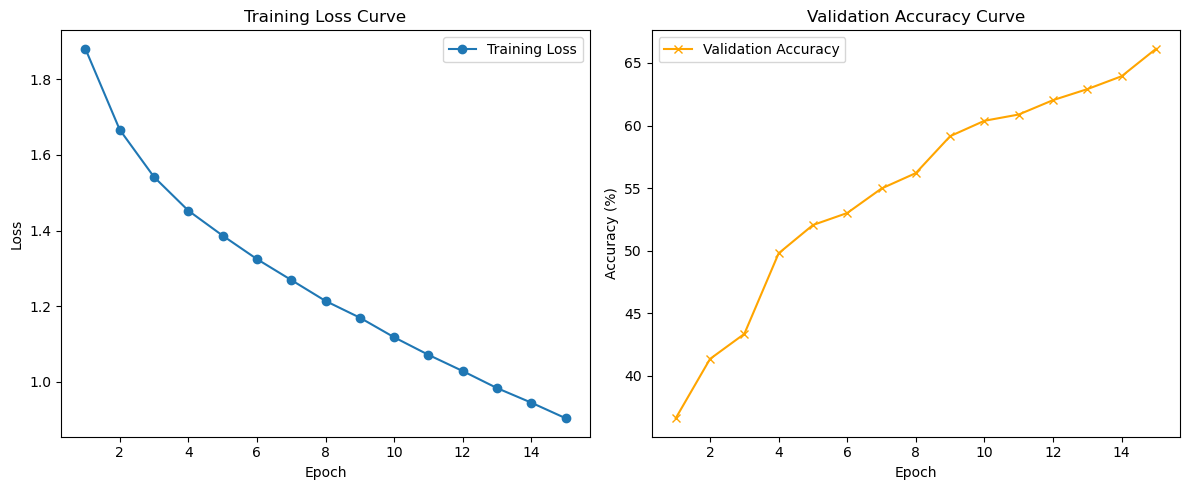

In [52]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_custom_cnn, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_custom_cnn, marker='x', color='orange', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()


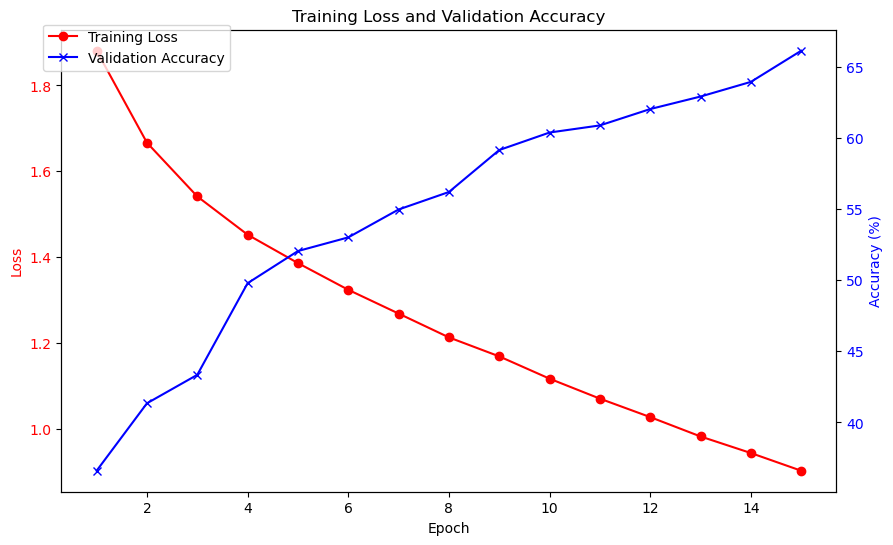

In [71]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss
ax1.plot(range(1, num_epochs + 1), train_losses_custom_cnn, marker='o', color='red', label='Training Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title("Training Loss and Validation Accuracy")

# Add a secondary y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, num_epochs + 1), val_accuracies_custom_cnn, marker='x', color='blue', label='Validation Accuracy')
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding legends for both curves
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

In [53]:
summary(custom_cnn_model, input_size=(64, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNNBaseline                        [64, 10]                  --
├─Sequential: 1-1                        [64, 128, 4, 4]           --
│    └─Conv2d: 2-1                       [64, 32, 32, 32]          896
│    └─ReLU: 2-2                         [64, 32, 32, 32]          --
│    └─MaxPool2d: 2-3                    [64, 32, 16, 16]          --
│    └─Conv2d: 2-4                       [64, 64, 16, 16]          18,496
│    └─ReLU: 2-5                         [64, 64, 16, 16]          --
│    └─MaxPool2d: 2-6                    [64, 64, 8, 8]            --
│    └─Conv2d: 2-7                       [64, 128, 8, 8]           73,856
│    └─ReLU: 2-8                         [64, 128, 8, 8]           --
│    └─MaxPool2d: 2-9                    [64, 128, 4, 4]           --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Flatten: 2-10                     [64, 2048]                --
│    └

In [51]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_cnn_model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop with training and validation accuracy calculation
num_epochs = 15
train_losses_custom_cnn = []
val_accuracies_custom_cnn = []

for epoch in range(num_epochs):
    custom_cnn_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = custom_cnn_model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    train_losses_custom_cnn.append(epoch_loss)
    
    train_accuracy = 100 * correct_train / total_train
    
    custom_cnn_model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = custom_cnn_model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_custom_cnn.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/15], Loss: 1.8808, Training Accuracy: 32.95%, Validation Accuracy: 36.61%
Epoch [2/15], Loss: 1.6667, Training Accuracy: 39.34%, Validation Accuracy: 41.35%
Epoch [3/15], Loss: 1.5417, Training Accuracy: 44.08%, Validation Accuracy: 43.35%
Epoch [4/15], Loss: 1.4526, Training Accuracy: 47.41%, Validation Accuracy: 49.79%
Epoch [5/15], Loss: 1.3866, Training Accuracy: 50.05%, Validation Accuracy: 52.05%
Epoch [6/15], Loss: 1.3244, Training Accuracy: 52.32%, Validation Accuracy: 53.01%
Epoch [7/15], Loss: 1.2691, Training Accuracy: 54.66%, Validation Accuracy: 54.97%
Epoch [8/15], Loss: 1.2137, Training Accuracy: 56.71%, Validation Accuracy: 56.20%
Epoch [9/15], Loss: 1.1694, Training Accuracy: 58.67%, Validation Accuracy: 59.15%
Epoch [10/15], Loss: 1.1176, Training Accuracy: 60.43%, Validation Accuracy: 60.38%
Epoch [11/15], Loss: 1.0711, Training Accuracy: 62.28%, Validation Accuracy: 60.88%
Epoch [12/15], Loss: 1.0282, Training Accuracy: 63.88%, Validation Accuracy: 62.03%
E

### Performing Hyper Parameter Tuning on the CNN Architecture built

In [56]:
# Define an improved custom CNN with Dropout layers for regularization
class ImprovedCustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer with 50% probability
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the improved CNN model and move it to the device
custom_cnn_model_dropout = ImprovedCustomCNN().to(device)

In [57]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with a suitable learning rate for Adam
optimizer = optim.Adam(custom_cnn_model_dropout.parameters(), lr=0.001, weight_decay=1e-4)

# Define a learning rate scheduler to decrease the learning rate after a certain number of epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop with training and validation accuracy calculation
num_epochs = 15
train_losses_custom_cnn_dropout = []
val_accuracies_custom_cnn_dropout = []

for epoch in range(num_epochs):
    custom_cnn_model_dropout.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = custom_cnn_model_dropout(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    train_losses_custom_cnn_dropout.append(epoch_loss)
    
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    custom_cnn_model_dropout.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = custom_cnn_model_dropout(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_custom_cnn_dropout.append(val_accuracy)

    # Step the scheduler after each epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/15], Loss: 1.6050, Training Accuracy: 40.53%, Validation Accuracy: 51.82%
Epoch [2/15], Loss: 1.2371, Training Accuracy: 56.13%, Validation Accuracy: 64.54%
Epoch [3/15], Loss: 1.0808, Training Accuracy: 62.73%, Validation Accuracy: 66.75%
Epoch [4/15], Loss: 0.9725, Training Accuracy: 66.73%, Validation Accuracy: 66.03%
Epoch [5/15], Loss: 0.9013, Training Accuracy: 69.51%, Validation Accuracy: 71.27%
Epoch [6/15], Loss: 0.8294, Training Accuracy: 71.88%, Validation Accuracy: 72.62%
Epoch [7/15], Loss: 0.7825, Training Accuracy: 73.69%, Validation Accuracy: 74.40%
Epoch [8/15], Loss: 0.7300, Training Accuracy: 75.45%, Validation Accuracy: 74.10%
Epoch [9/15], Loss: 0.6809, Training Accuracy: 77.03%, Validation Accuracy: 76.03%
Epoch [10/15], Loss: 0.6430, Training Accuracy: 78.38%, Validation Accuracy: 75.78%
Epoch [11/15], Loss: 0.5128, Training Accuracy: 82.64%, Validation Accuracy: 79.13%
Epoch [12/15], Loss: 0.4636, Training Accuracy: 84.24%, Validation Accuracy: 79.47%
E

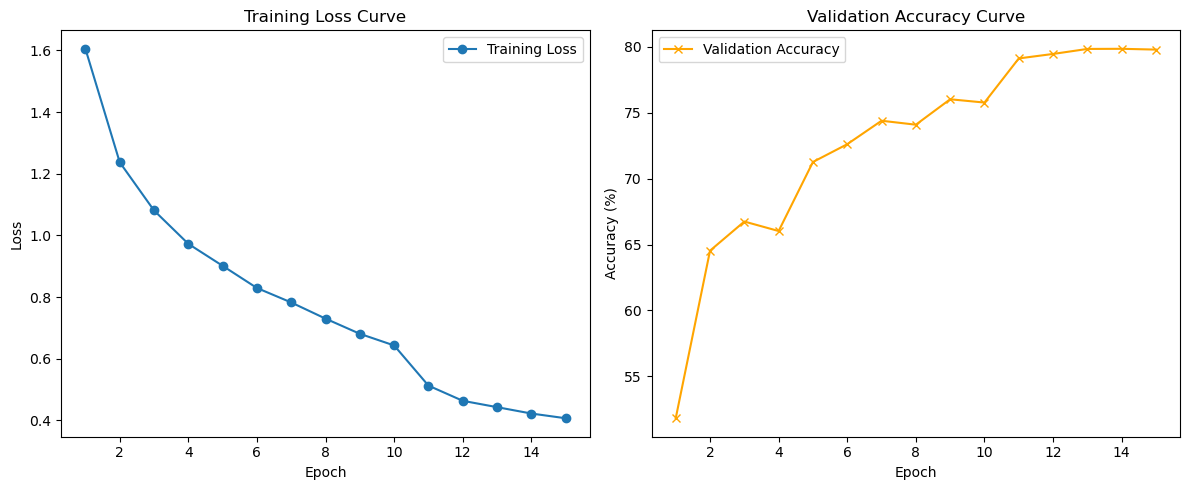

In [58]:
# Plot training loss and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_custom_cnn_dropout, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_custom_cnn_dropout, marker='x', color='orange', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


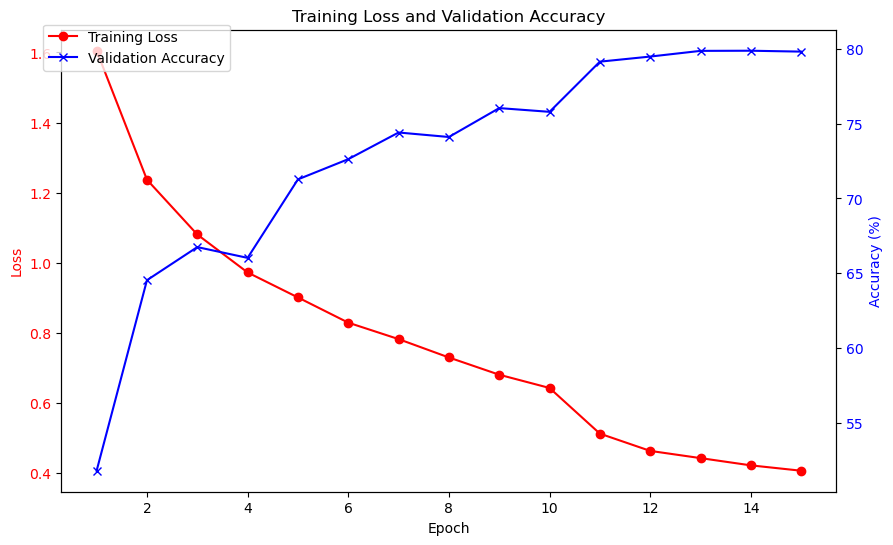

In [72]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss
ax1.plot(range(1, num_epochs + 1), train_losses_custom_cnn_dropout, marker='o', color='red', label='Training Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title("Training Loss and Validation Accuracy")

# Add a secondary y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, num_epochs + 1), val_accuracies_custom_cnn_dropout, marker='x', color='blue', label='Validation Accuracy')
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding legends for both curves
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

In [59]:
summary(custom_cnn_model_dropout, input_size=(64, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCustomCNN                        [64, 10]                  --
├─Sequential: 1-1                        [64, 128, 4, 4]           --
│    └─Conv2d: 2-1                       [64, 32, 32, 32]          896
│    └─BatchNorm2d: 2-2                  [64, 32, 32, 32]          64
│    └─ReLU: 2-3                         [64, 32, 32, 32]          --
│    └─MaxPool2d: 2-4                    [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 64, 16, 16]          18,496
│    └─BatchNorm2d: 2-6                  [64, 64, 16, 16]          128
│    └─ReLU: 2-7                         [64, 64, 16, 16]          --
│    └─MaxPool2d: 2-8                    [64, 64, 8, 8]            --
│    └─Conv2d: 2-9                       [64, 128, 8, 8]           73,856
│    └─BatchNorm2d: 2-10                 [64, 128, 8, 8]           256
│    └─ReLU: 2-11                        [64, 128, 8, 8]           --
│   

In [60]:
# Number of classes in CIFAR-10
num_classes = 10

# Evaluate the model on the test dataset
custom_cnn_model_dropout.eval()  # Set the model to evaluation mode
correct_test = 0
total_test = 0

# Arrays to hold the true labels and predicted probabilities for AUC calculation
y_true = []
y_score = []

# No gradient computation needed during evaluation
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass to get model predictions
        outputs = custom_cnn_model_dropout(images)
        
        # Calculate predictions
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        # Append true labels and probabilities for AUC
        y_true.extend(labels.cpu().numpy())
        y_score.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Softmax to get probabilities

# Calculate test accuracy
test_accuracy_custom_cnn = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy_custom_cnn:.2f}%")

Test Accuracy: 80.10%


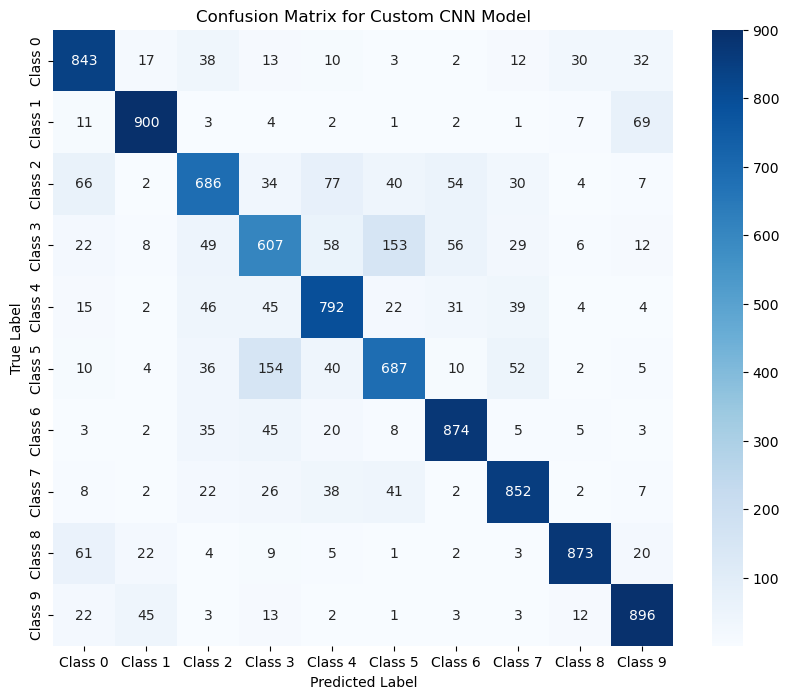

In [80]:
y_pred = np.argmax(y_score, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Custom CNN Model")
plt.show()

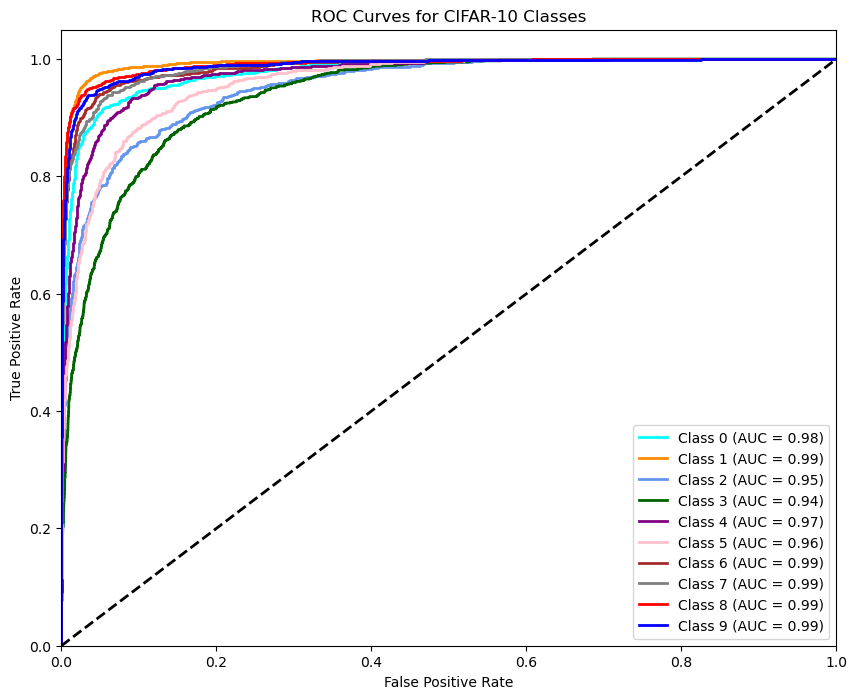

In [61]:
y_true = np.array(y_true)
y_score = np.array(y_score)

# Binarize the true labels for multi-class AUC calculation
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'pink', 'brown', 'grey', 'red', 'blue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CIFAR-10 Classes')
plt.legend(loc="lower right")
plt.show()

### Importing the RESNET 18 model without pre-trained weights

In [5]:
# Define the ResNet-18 model without pre-trained weights and store it in `resnet_model`
resnet_model = models.resnet18(weights=None)  # pretrained=False initializes weights randomly
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)  # Adjust final layer for 10 CIFAR-10 classes
resnet_model =  resnet_model.to(device).to(torch.float32)

### Baseline Model 

In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop with training and validation accuracy calculation
num_epochs = 15
train_losses_resnet18 = []
val_accuracies_resnet18 = []

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in trainloader:
        # Move images and labels to device and ensure they are float32
        images = images.to(device).to(torch.float32)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Average training loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    train_losses_resnet18.append(epoch_loss)
    
    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    resnet_model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            # Move images and labels to device and ensure they are float32
            images = images.to(device).to(torch.float32)
            labels = labels.to(device)
            outputs = resnet_model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_resnet18.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/15], Loss: 1.3089, Training Accuracy: 52.81%, Validation Accuracy: 49.27%
Epoch [2/15], Loss: 1.2411, Training Accuracy: 55.37%, Validation Accuracy: 51.99%
Epoch [3/15], Loss: 1.1671, Training Accuracy: 58.47%, Validation Accuracy: 52.72%
Epoch [4/15], Loss: 1.1027, Training Accuracy: 60.94%, Validation Accuracy: 53.03%
Epoch [5/15], Loss: 1.0424, Training Accuracy: 63.12%, Validation Accuracy: 54.31%
Epoch [6/15], Loss: 0.9796, Training Accuracy: 65.53%, Validation Accuracy: 54.90%
Epoch [7/15], Loss: 0.9236, Training Accuracy: 67.95%, Validation Accuracy: 55.32%
Epoch [8/15], Loss: 0.8614, Training Accuracy: 70.34%, Validation Accuracy: 55.44%
Epoch [9/15], Loss: 0.8090, Training Accuracy: 72.34%, Validation Accuracy: 55.76%
Epoch [10/15], Loss: 0.7500, Training Accuracy: 74.55%, Validation Accuracy: 55.81%
Epoch [11/15], Loss: 0.6947, Training Accuracy: 76.34%, Validation Accuracy: 56.38%
Epoch [12/15], Loss: 0.6361, Training Accuracy: 78.81%, Validation Accuracy: 56.20%
E

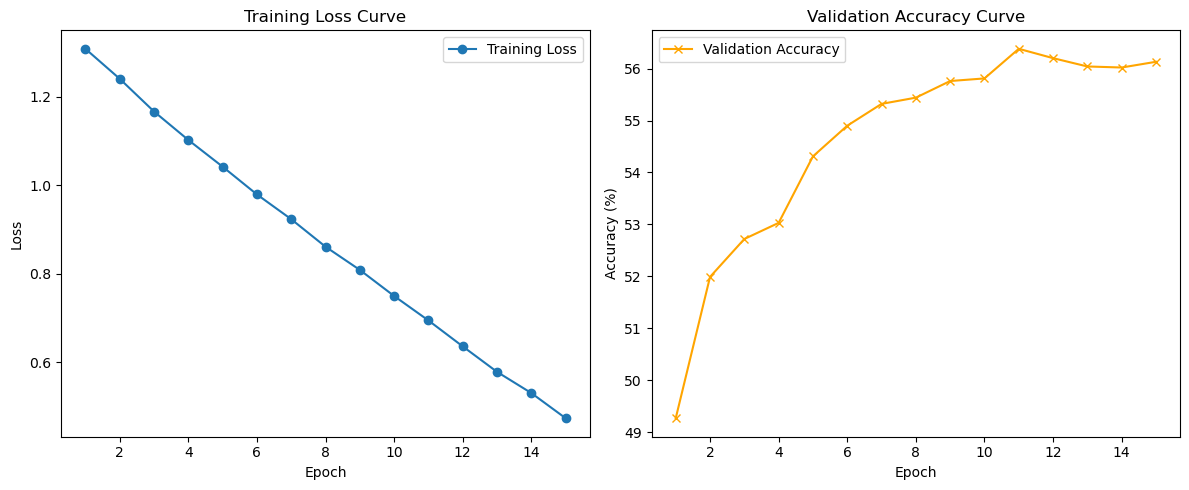

In [10]:
plt.figure(figsize=(12, 5))
# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_resnet18, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_resnet18, marker='x', color='orange', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

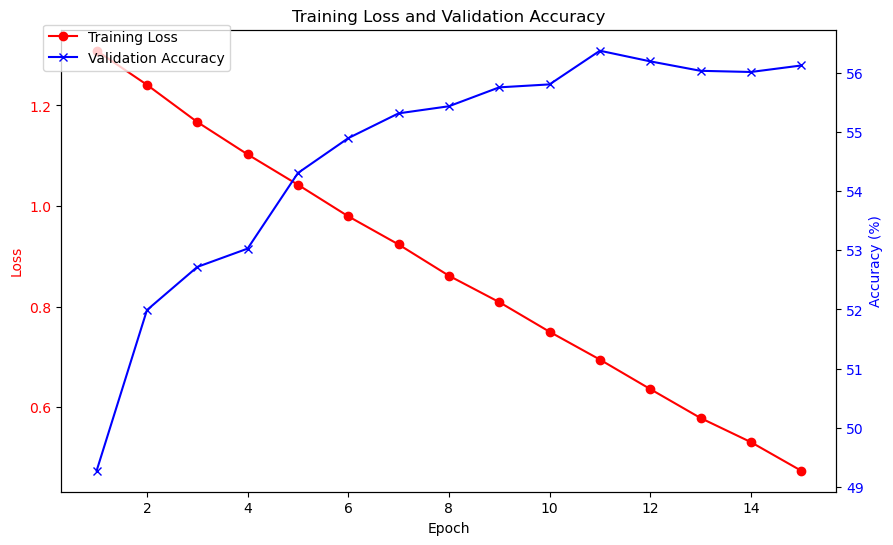

In [73]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss
ax1.plot(range(1, num_epochs + 1), train_losses_resnet18, marker='o', color='red', label='Training Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title("Training Loss and Validation Accuracy")

# Add a secondary y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, num_epochs + 1), val_accuracies_resnet18, marker='x', color='blue', label='Validation Accuracy')
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding legends for both curves
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

In [11]:
resnet_model = resnet_model.to(device)
summary(resnet_model, input_size=(64, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 16, 16]          128
├─ReLU: 1-3                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 64, 8, 8]            --
├─Sequential: 1-5                        [64, 64, 8, 8]            --
│    └─BasicBlock: 2-1                   [64, 64, 8, 8]            --
│    │    └─Conv2d: 3-1                  [64, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [64, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [64, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 8, 8]            128
│    │    └─ReLU: 3-6                    [64, 64, 8, 8]            --
│

### Hyper parameter Tuning 

In [12]:
# Data Augmentation 
class CIFAR10DataLoaderAugmented(CIFAR10DataLoader):
    def __init__(self, batch_size=64, validation_split=0.2, random_state=42, num_workers=2):
        super().__init__(batch_size, validation_split, random_state, num_workers)
        
        # Override train_transform with data augmentation
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Reload the full training dataset with the new transform
        self.full_trainset.transform = self.train_transform
        self.trainset, self.valset = self.split_train_validation()  # Re-split with updated transform
        self.trainloader = DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

# Usage for augmented model
data_loader_augmented = CIFAR10DataLoaderAugmented(batch_size=64)
trainloader_aug, valloader_aug, testloader_aug = data_loader_augmented.get_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Define the ResNet-18 model without pre-trained weights and modify for CIFAR-10
class ResNet18WithDropout(models.ResNet):
    def __init__(self):
        super().__init__(models.resnet.BasicBlock, [2, 2, 2, 2])
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout with 50% probability
            nn.Linear(self.fc.in_features, 10)
        )

resnet_model_dropout1 = ResNet18WithDropout()

resnet_model_dropout1 = resnet_model_dropout1.to(device).to(torch.float32)
# Define the loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_dropout1.parameters(), lr=0.001, weight_decay=1e-4)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop with regularization, learning rate scheduling, and dropout
num_epochs = 15  # Extended training epochs
train_losses_resnet18_dropout1 = []
val_accuracies_resnet18_dropout1 = []

for epoch in range(num_epochs):
    resnet_model_dropout1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase with augmented data loader
    for images, labels in trainloader_aug:
        images = images.to(device).to(torch.float32)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet_model_dropout1(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Update learning rate scheduler
    scheduler.step()

    # Average training loss for the epoch
    epoch_loss = running_loss / len(trainloader_aug)
    train_losses_resnet18_dropout1.append(epoch_loss)
    
    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    resnet_model_dropout1.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader_aug:
            images = images.to(device).to(torch.float32)
            labels = labels.to(device)
            outputs = resnet_model_dropout1(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_resnet18_dropout1.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/15], Loss: 1.6974, Training Accuracy: 38.92%, Validation Accuracy: 45.25%
Epoch [2/15], Loss: 1.3251, Training Accuracy: 52.76%, Validation Accuracy: 56.29%
Epoch [3/15], Loss: 1.1508, Training Accuracy: 59.38%, Validation Accuracy: 61.03%
Epoch [4/15], Loss: 1.0482, Training Accuracy: 63.38%, Validation Accuracy: 64.54%
Epoch [5/15], Loss: 0.9666, Training Accuracy: 66.27%, Validation Accuracy: 68.93%
Epoch [6/15], Loss: 0.8948, Training Accuracy: 68.98%, Validation Accuracy: 69.66%
Epoch [7/15], Loss: 0.8475, Training Accuracy: 71.05%, Validation Accuracy: 71.62%
Epoch [8/15], Loss: 0.8003, Training Accuracy: 72.79%, Validation Accuracy: 72.88%
Epoch [9/15], Loss: 0.7692, Training Accuracy: 73.67%, Validation Accuracy: 73.55%
Epoch [10/15], Loss: 0.7387, Training Accuracy: 74.75%, Validation Accuracy: 73.65%
Epoch [11/15], Loss: 0.5974, Training Accuracy: 79.47%, Validation Accuracy: 79.01%
Epoch [12/15], Loss: 0.5556, Training Accuracy: 80.92%, Validation Accuracy: 79.66%
E

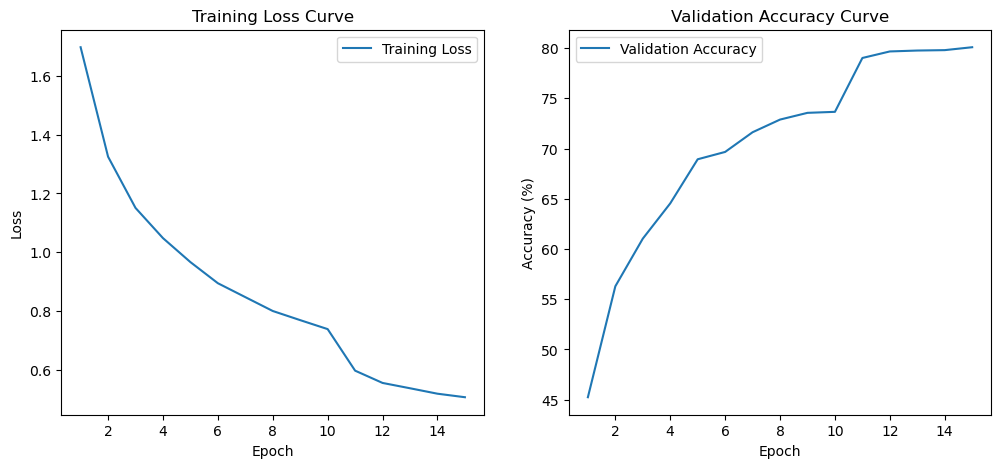

In [14]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_resnet18_dropout1, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_resnet18_dropout1, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()

plt.show()

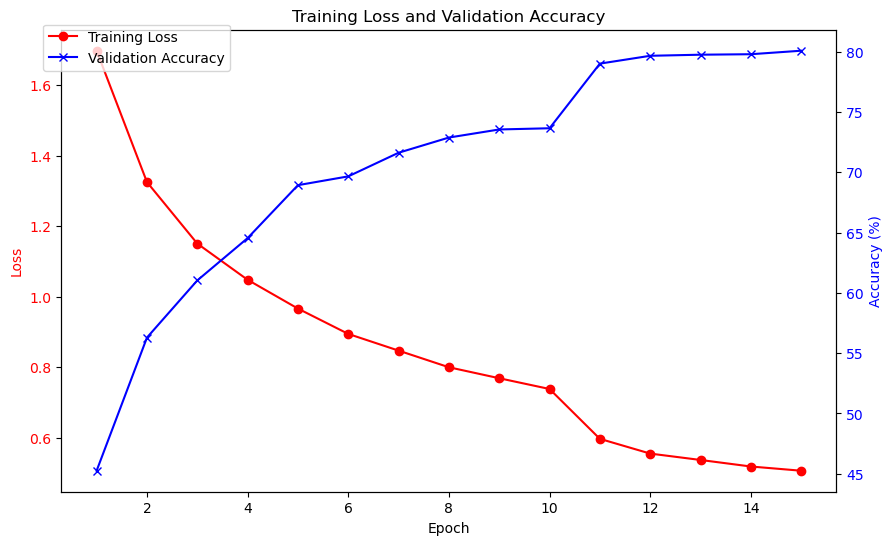

In [74]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss
ax1.plot(range(1, num_epochs + 1), train_losses_resnet18_dropout1, marker='o', color='red', label='Training Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title("Training Loss and Validation Accuracy")

# Add a secondary y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, num_epochs + 1), val_accuracies_resnet18_dropout1, marker='x', color='blue', label='Validation Accuracy')
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding legends for both curves
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

In [15]:
summary(resnet_model_dropout1, input_size=(64, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18WithDropout                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 16, 16]          128
├─ReLU: 1-3                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 64, 8, 8]            --
├─Sequential: 1-5                        [64, 64, 8, 8]            --
│    └─BasicBlock: 2-1                   [64, 64, 8, 8]            --
│    │    └─Conv2d: 3-1                  [64, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [64, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [64, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 8, 8]            128
│    │    └─ReLU: 3-6                    [64, 64, 8, 8]            --
│

In [16]:
# Ensure the model is in evaluation mode for testing
resnet_model_dropout1.eval()

# Initialize counters for correct predictions and total samples
correct_test = 0
total_test = 0

# No gradient computation is needed during evaluation
with torch.no_grad():
    for images, labels in testloader_aug:
        images = images.to(device).to(torch.float32)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet_model_dropout1(images)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update counters
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy_resnet18_dropout1 = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy_resnet18_dropout1:.2f}%")


Test Accuracy: 80.99%


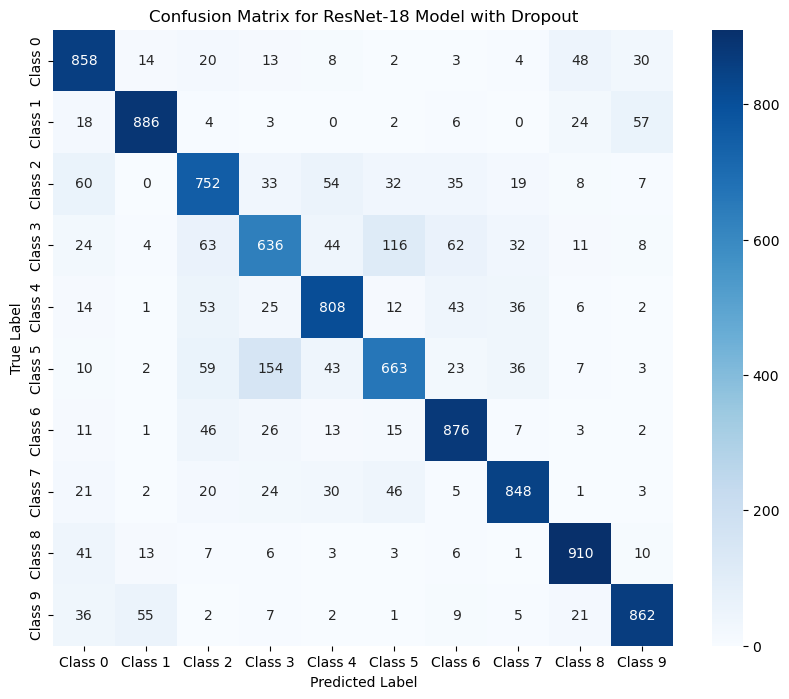

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ResNet-18 Model with Dropout")
plt.show()


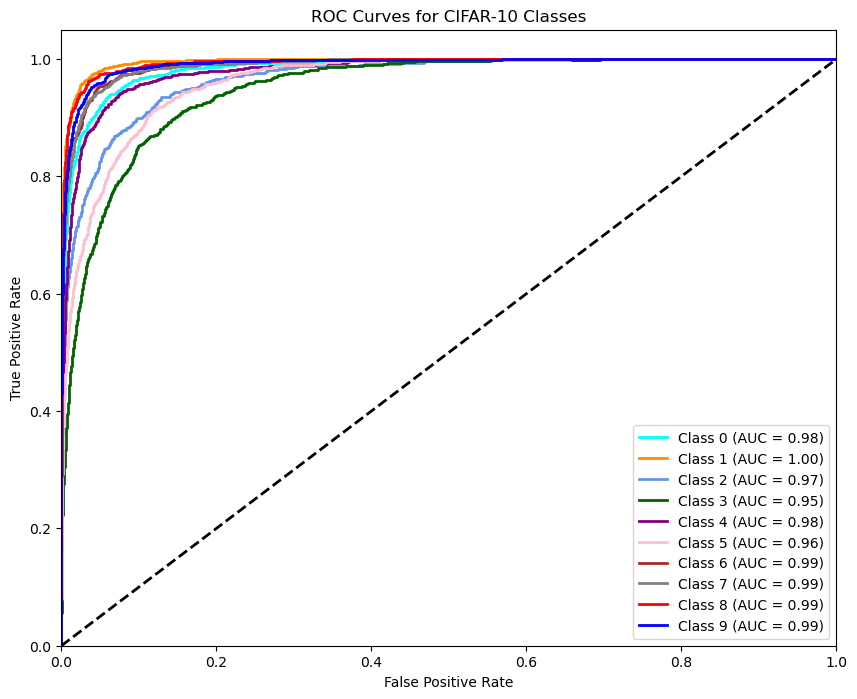

In [17]:
# Number of classes in CIFAR-10
num_classes = 10

# Arrays to hold the true labels and predicted probabilities
y_true = []
y_score = []

# Set the model to evaluation mode
resnet_model_dropout1.eval()
with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in testloader_aug:
        images = images.to(device).to(torch.float32)
        labels = labels.to(device)
        
        # Forward pass to get output scores
        outputs = resnet_model_dropout1(images)
        
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)
        
        # Append true labels and predicted probabilities
        y_true.extend(labels.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for use with sklearn
y_true = np.array(y_true)
y_score = np.array(y_score)

# Binarize the true labels for multi-class AUC calculation
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'pink', 'brown', 'grey', 'red', 'blue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CIFAR-10 Classes')
plt.legend(loc="lower right")
plt.show()

# AlexNet 

In [18]:
class AlexNetBaseline(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetBaseline, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),  # Adjusted kernel size and stride
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Pass a dummy input through the features to determine the output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            output = self.features(dummy_input)
            flattened_size = output.view(1, -1).size(1)

        # Define the classifier with the correct flattened size
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the baseline AlexNet model and move it to the device
alexnet_model = AlexNetBaseline().to(device)

### Baseline for AlexNet without any pre-trained weights

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.01, weight_decay=1e-4)

# Training and validation loop
num_epochs = 15
train_losses_alexnet = []
val_accuracies_alexnet = []

for epoch in range(num_epochs):
    alexnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in trainloader:
        images, labels = images.to(device).to(torch.float32), labels.to(device)

        optimizer.zero_grad()

        outputs = alexnet_model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    train_losses_alexnet.append(epoch_loss)
    
    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    alexnet_model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device).to(torch.float32), labels.to(device)
            outputs = alexnet_model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_alexnet.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/15], Loss: 2.2984, Training Accuracy: 11.25%, Validation Accuracy: 10.18%
Epoch [2/15], Loss: 2.2285, Training Accuracy: 14.12%, Validation Accuracy: 23.24%
Epoch [3/15], Loss: 1.9574, Training Accuracy: 24.62%, Validation Accuracy: 30.41%
Epoch [4/15], Loss: 1.8116, Training Accuracy: 30.50%, Validation Accuracy: 33.23%
Epoch [5/15], Loss: 1.7240, Training Accuracy: 34.23%, Validation Accuracy: 37.48%
Epoch [6/15], Loss: 1.6481, Training Accuracy: 37.62%, Validation Accuracy: 38.64%
Epoch [7/15], Loss: 1.5619, Training Accuracy: 41.15%, Validation Accuracy: 43.16%
Epoch [8/15], Loss: 1.4843, Training Accuracy: 44.43%, Validation Accuracy: 47.40%
Epoch [9/15], Loss: 1.4143, Training Accuracy: 47.66%, Validation Accuracy: 48.21%
Epoch [10/15], Loss: 1.3410, Training Accuracy: 50.25%, Validation Accuracy: 52.90%
Epoch [11/15], Loss: 1.2671, Training Accuracy: 53.53%, Validation Accuracy: 54.90%
Epoch [12/15], Loss: 1.1931, Training Accuracy: 56.29%, Validation Accuracy: 55.67%
E

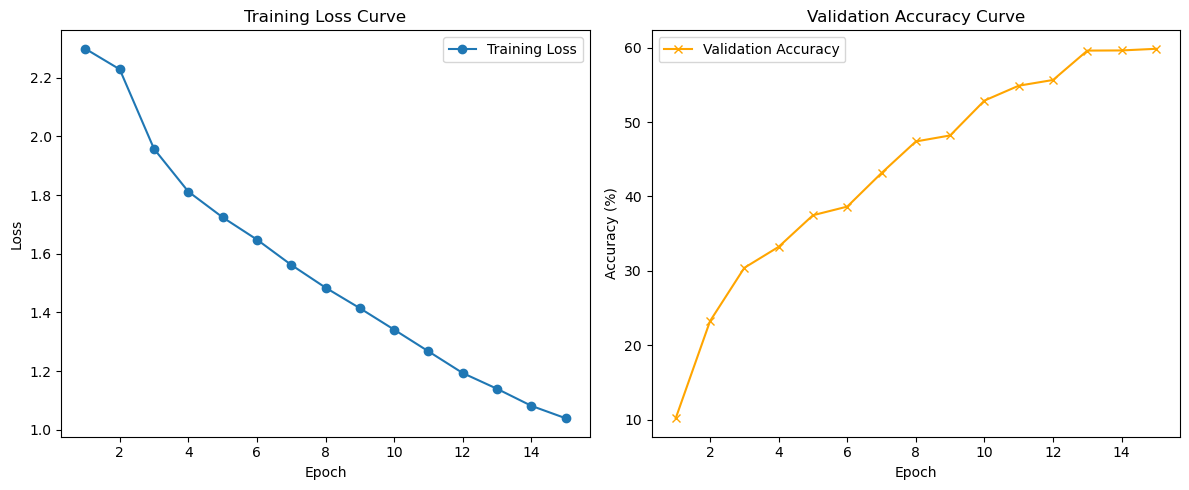

In [21]:
# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_alexnet, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_alexnet, marker='x', color='orange', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

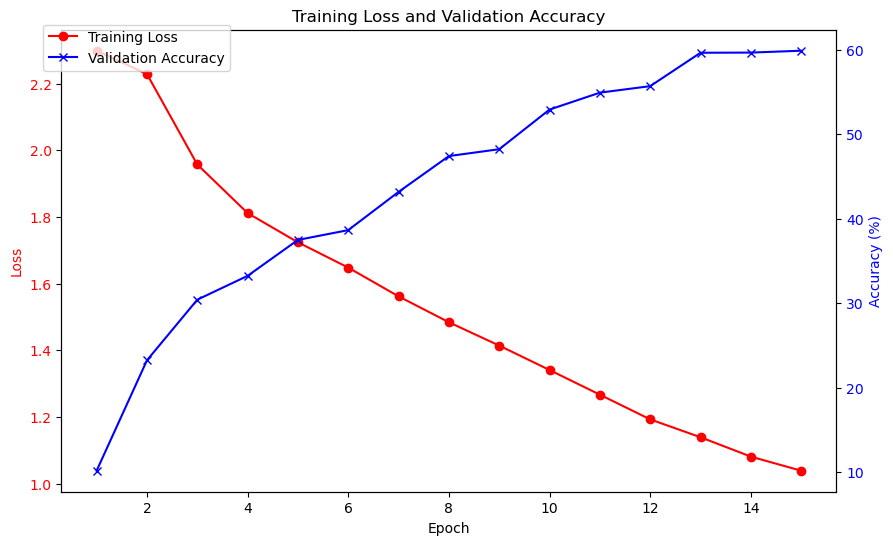

In [75]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss
ax1.plot(range(1, num_epochs + 1), train_losses_alexnet, marker='o', color='red', label='Training Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title("Training Loss and Validation Accuracy")

# Add a secondary y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, num_epochs + 1), val_accuracies_alexnet, marker='x', color='blue', label='Validation Accuracy')
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding legends for both curves
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

In [22]:
summary(alexnet_model, input_size=(64, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
AlexNetBaseline                          [64, 10]                  --
├─Sequential: 1-1                        [64, 256, 3, 3]           --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          4,864
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-3                    [64, 64, 15, 15]          --
│    └─Conv2d: 2-4                       [64, 192, 15, 15]         307,392
│    └─ReLU: 2-5                         [64, 192, 15, 15]         --
│    └─MaxPool2d: 2-6                    [64, 192, 7, 7]           --
│    └─Conv2d: 2-7                       [64, 384, 7, 7]           663,936
│    └─ReLU: 2-8                         [64, 384, 7, 7]           --
│    └─Conv2d: 2-9                       [64, 256, 7, 7]           884,992
│    └─ReLU: 2-10                        [64, 256, 7, 7]           --
│    └─Conv2d: 2-11                      [64, 256, 7, 7]           

### Hyperparameter Tuning

In [23]:
class AlexNetTuned(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetTuned, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Calculate the flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            flattened_size = self.features(dummy_input).view(1, -1).size(1)

        # Define the classifier with additional dropout for regularization
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the tuned AlexNet model and move it to the device
alexnet_model_dropout1 = AlexNetTuned().to(device)

In [24]:
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with a learning rate suitable for Adam
optimizer = optim.Adam(alexnet_model_dropout1.parameters(), lr=0.001, weight_decay=1e-4)

# Define a learning rate scheduler to decrease the learning rate after certain epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training and validation loop
num_epochs = 15
train_losses_alexnet_dropout1 = []
val_accuracies_alexnet_dropout1 = []

for epoch in range(num_epochs):
    alexnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in trainloader:
        images, labels = images.to(device).to(torch.float32), labels.to(device)

        optimizer.zero_grad()

        outputs = alexnet_model_dropout1(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    train_losses_alexnet_dropout1.append(epoch_loss)
    
    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    alexnet_model_dropout1.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device).to(torch.float32), labels.to(device)
            outputs = alexnet_model_dropout1(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_alexnet_dropout1.append(val_accuracy)

    # Step the scheduler
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/15], Loss: 1.8391, Training Accuracy: 27.88%, Validation Accuracy: 36.61%
Epoch [2/15], Loss: 1.4487, Training Accuracy: 45.72%, Validation Accuracy: 50.51%
Epoch [3/15], Loss: 1.2655, Training Accuracy: 53.97%, Validation Accuracy: 56.55%
Epoch [4/15], Loss: 1.1390, Training Accuracy: 58.74%, Validation Accuracy: 58.69%
Epoch [5/15], Loss: 1.0493, Training Accuracy: 62.44%, Validation Accuracy: 60.04%
Epoch [6/15], Loss: 0.9765, Training Accuracy: 65.43%, Validation Accuracy: 63.29%
Epoch [7/15], Loss: 0.9111, Training Accuracy: 67.85%, Validation Accuracy: 64.61%
Epoch [8/15], Loss: 0.8521, Training Accuracy: 69.97%, Validation Accuracy: 66.04%
Epoch [9/15], Loss: 0.7959, Training Accuracy: 71.88%, Validation Accuracy: 66.99%
Epoch [10/15], Loss: 0.7334, Training Accuracy: 74.09%, Validation Accuracy: 67.96%
Epoch [11/15], Loss: 0.5331, Training Accuracy: 81.29%, Validation Accuracy: 69.97%
Epoch [12/15], Loss: 0.4672, Training Accuracy: 83.57%, Validation Accuracy: 69.83%
E

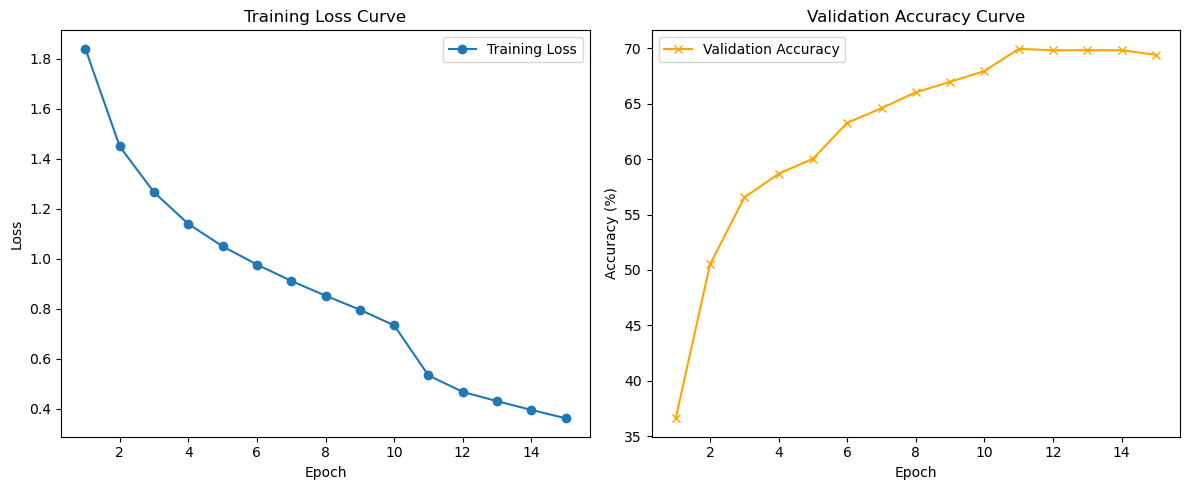

In [26]:
# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_alexnet_dropout1, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_alexnet_dropout1, marker='x', color='orange', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

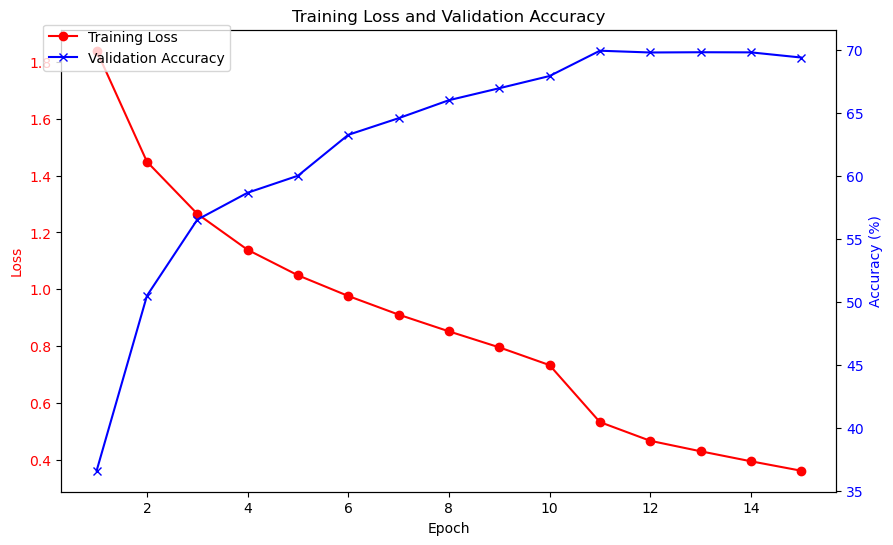

In [76]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss
ax1.plot(range(1, num_epochs + 1), train_losses_alexnet_dropout1, marker='o', color='red', label='Training Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title("Training Loss and Validation Accuracy")

# Add a secondary y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, num_epochs + 1), val_accuracies_alexnet_dropout1, marker='x', color='blue', label='Validation Accuracy')
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding legends for both curves
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

In [27]:
summary(alexnet_model_dropout1, input_size=(64, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
AlexNetTuned                             [64, 10]                  --
├─Sequential: 1-1                        [64, 256, 3, 3]           --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          4,864
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-3                    [64, 64, 15, 15]          --
│    └─Conv2d: 2-4                       [64, 192, 15, 15]         307,392
│    └─ReLU: 2-5                         [64, 192, 15, 15]         --
│    └─MaxPool2d: 2-6                    [64, 192, 7, 7]           --
│    └─Conv2d: 2-7                       [64, 384, 7, 7]           663,936
│    └─ReLU: 2-8                         [64, 384, 7, 7]           --
│    └─Conv2d: 2-9                       [64, 256, 7, 7]           884,992
│    └─ReLU: 2-10                        [64, 256, 7, 7]           --
│    └─Conv2d: 2-11                      [64, 256, 7, 7]           

In [28]:
# Evaluate the model on the test dataset
alexnet_model_dropout1.eval()  # Set the model to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in testloader:
        images, labels = images.to(device).to(torch.float32), labels.to(device)
        
        # Forward pass
        outputs = alexnet_model_dropout1(images)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update the total number of labels and correctly predicted labels
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy_alexnet_dropout1 = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy_alexnet_dropout1:.2f}%")

Test Accuracy: 69.76%


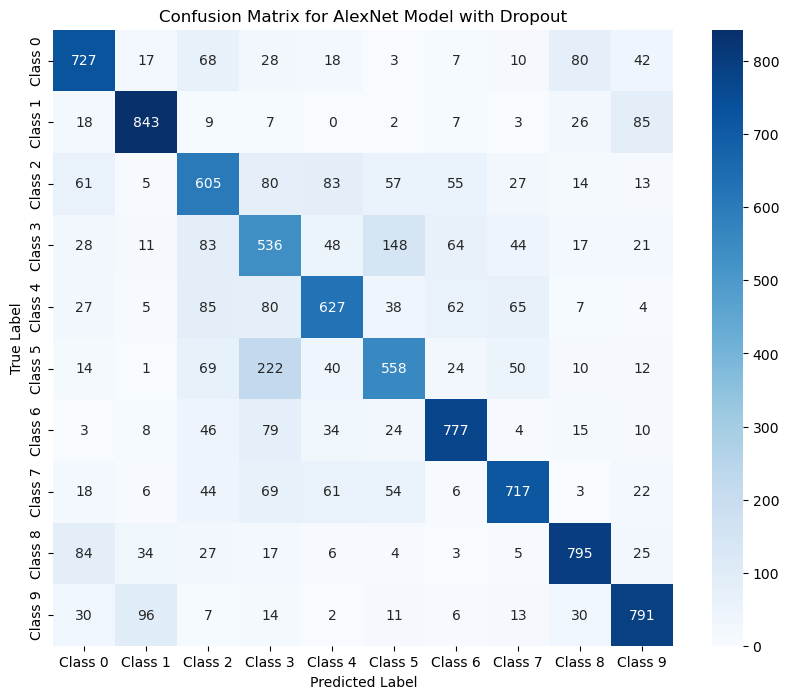

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for AlexNet Model with Dropout")
plt.show()


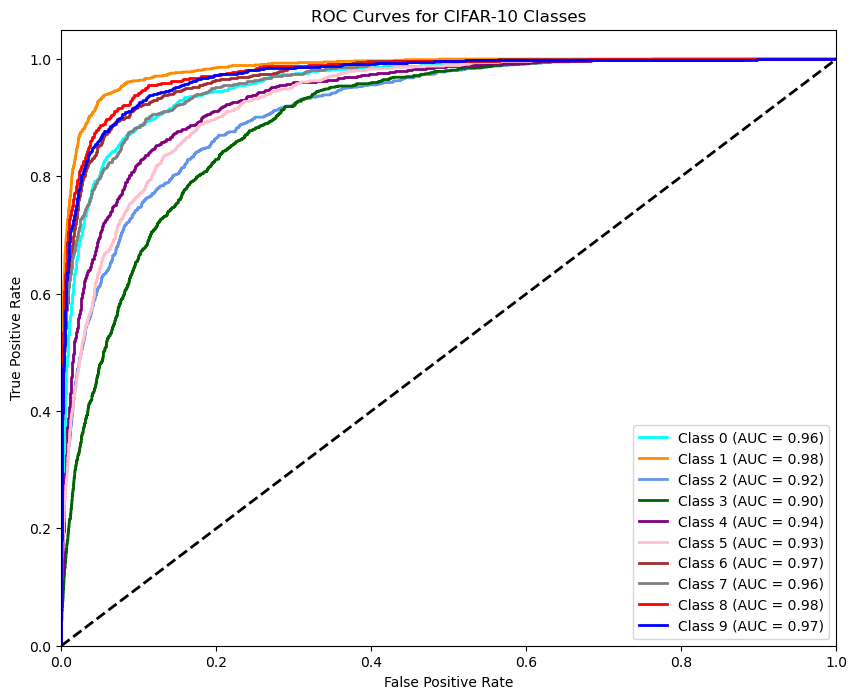

In [29]:
# Binarize the labels for multi-class AUC calculation
num_classes = 10
y_true = []
y_score = []

alexnet_model_dropout1.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in testloader:
        images = images.to(device).to(torch.float32)
        labels = labels.to(device)
        
        # Forward pass
        outputs = alexnet_model_dropout1(images)
        
        # Get the softmax probabilities for each class
        probs = torch.softmax(outputs, dim=1)
        
        # Append true labels and predicted probabilities
        y_true.extend(labels.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for sklearn
y_true = np.array(y_true)
y_score = np.array(y_score)

# Binarize the labels for ROC curve calculation
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'pink', 'brown', 'grey', 'red', 'blue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CIFAR-10 Classes')
plt.legend(loc="lower right")
plt.show()


### MobileNet

### Baseline for MobileNet

In [30]:
# Define the MobileNetV2 model without pre-trained weights
mobilenet_model = models.mobilenet_v2(weights=None)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.last_channel, 10)  # Adjust final layer for 10 CIFAR-10 classes
mobilenet_model = mobilenet_model.to(device).to(torch.float32)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet_model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 15
train_losses_mobilenet = []
val_accuracies_mobilenet = []

for epoch in range(num_epochs):
    mobilenet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in trainloader:
        # Move images and labels to device and ensure they are float32
        images = images.to(device).to(torch.float32)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = mobilenet_model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Average training loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    train_losses_mobilenet.append(epoch_loss)
    
    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    mobilenet_model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            # Move images and labels to device and ensure they are float32
            images = images.to(device).to(torch.float32)
            labels = labels.to(device)
            outputs = mobilenet_model(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_mobilenet.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/15], Loss: 2.2870, Training Accuracy: 13.77%, Validation Accuracy: 16.96%
Epoch [2/15], Loss: 2.1210, Training Accuracy: 19.28%, Validation Accuracy: 21.77%
Epoch [3/15], Loss: 1.9969, Training Accuracy: 23.78%, Validation Accuracy: 25.47%
Epoch [4/15], Loss: 1.9074, Training Accuracy: 26.71%, Validation Accuracy: 29.07%
Epoch [5/15], Loss: 1.8402, Training Accuracy: 29.21%, Validation Accuracy: 30.58%
Epoch [6/15], Loss: 1.7845, Training Accuracy: 31.92%, Validation Accuracy: 32.94%
Epoch [7/15], Loss: 1.7353, Training Accuracy: 33.95%, Validation Accuracy: 34.53%
Epoch [8/15], Loss: 1.6968, Training Accuracy: 35.77%, Validation Accuracy: 36.83%
Epoch [9/15], Loss: 1.6588, Training Accuracy: 37.31%, Validation Accuracy: 38.39%
Epoch [10/15], Loss: 1.6222, Training Accuracy: 39.48%, Validation Accuracy: 40.24%
Epoch [11/15], Loss: 1.5884, Training Accuracy: 40.81%, Validation Accuracy: 41.02%
Epoch [12/15], Loss: 1.5638, Training Accuracy: 41.74%, Validation Accuracy: 41.63%
E

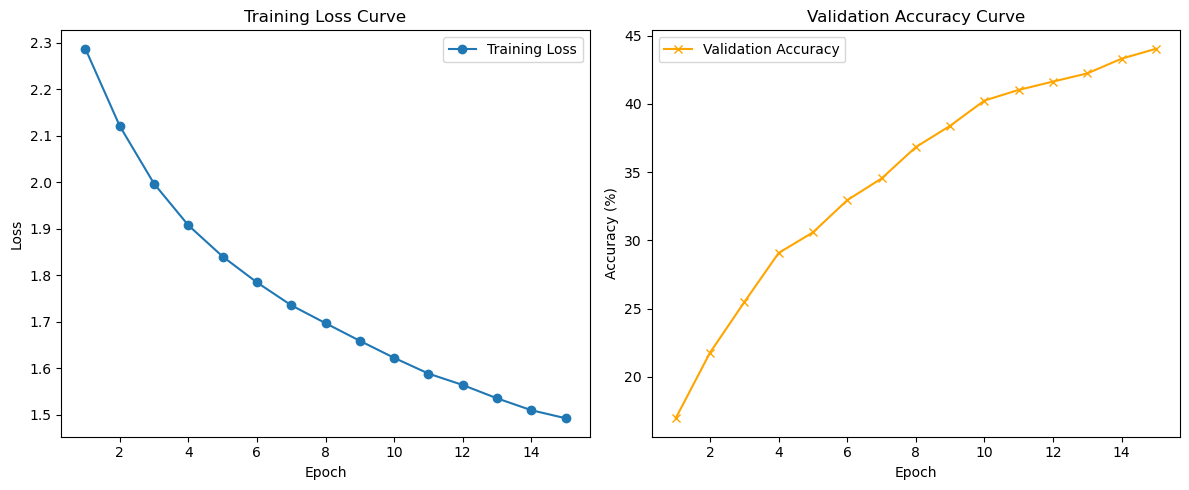

In [32]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_mobilenet, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_mobilenet, marker='x', color='orange', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
summary(mobilenet_model, input_size=(64, 3, 32, 32), device=device)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [64, 10]                  --
├─Sequential: 1-1                                  [64, 1280, 1, 1]          --
│    └─Conv2dNormActivation: 2-1                   [64, 32, 16, 16]          --
│    │    └─Conv2d: 3-1                            [64, 32, 16, 16]          864
│    │    └─BatchNorm2d: 3-2                       [64, 32, 16, 16]          64
│    │    └─ReLU6: 3-3                             [64, 32, 16, 16]          --
│    └─InvertedResidual: 2-2                       [64, 16, 16, 16]          --
│    │    └─Sequential: 3-4                        [64, 16, 16, 16]          896
│    └─InvertedResidual: 2-3                       [64, 24, 8, 8]            --
│    │    └─Sequential: 3-5                        [64, 24, 8, 8]            5,136
│    └─InvertedResidual: 2-4                       [64, 24, 8, 8]            --
│    │    └─Sequential: 3-6   

### Hyper Parameter Tuning

In [34]:
class CIFAR10DataLoaderAugmentedMobileNet(CIFAR10DataLoader):
    def __init__(self, batch_size=64, validation_split=0.2, random_state=42, num_workers=2):
        super().__init__(batch_size, validation_split, random_state, num_workers)
        
        # Override train_transform with data augmentation
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Reload the full training dataset with the new transform
        self.full_trainset.transform = self.train_transform
        self.trainset, self.valset = self.split_train_validation()  # Re-split with updated transform
        self.trainloader = DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

# Usage for augmented model
data_loader_augmented_mobilenet = CIFAR10DataLoaderAugmentedMobileNet(batch_size=64)
trainloader_aug_mobilenet, valloader_aug_mobilenet, testloader_aug_mobilenet = data_loader_augmented_mobilenet.get_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [35]:
class MobileNetV2WithDropout(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetV2WithDropout, self).__init__()
        self.mobilenet = models.mobilenet_v2(weights=None)  # Initialize without pretrained weights
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout for regularization
            nn.Linear(self.mobilenet.last_channel, num_classes)  # CIFAR-10 has 10 classes
        )
    
    def forward(self, x):
        return self.mobilenet(x)

# Instantiate the model and move it to the device
mobilenet_model_dropout1 = MobileNetV2WithDropout().to(device)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model_dropout1.parameters(), lr=0.001, weight_decay=1e-4)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop with regularization, learning rate scheduling, and dropout
num_epochs = 15
train_losses_mobilenet_dropout_1 = []
val_accuracies_mobilenet_dropout_1 = []

for epoch in range(num_epochs):
    mobilenet_model_dropout1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase with augmented data loader
    for images, labels in trainloader_aug_mobilenet:
        images, labels = images.to(device).to(torch.float32), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = mobilenet_model_dropout1(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Update learning rate scheduler
    scheduler.step()

    # Average training loss for the epoch
    epoch_loss = running_loss / len(trainloader_aug_mobilenet)
    train_losses_mobilenet_dropout_1.append(epoch_loss)
    
    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    mobilenet_model_dropout1.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in valloader_aug_mobilenet:
            images, labels = images.to(device).to(torch.float32), labels.to(device)
            outputs = mobilenet_model_dropout1(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    val_accuracies_mobilenet_dropout_1.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/15], Loss: 1.2160, Training Accuracy: 56.94%, Validation Accuracy: 58.97%
Epoch [2/15], Loss: 1.1975, Training Accuracy: 57.77%, Validation Accuracy: 59.41%
Epoch [3/15], Loss: 1.1772, Training Accuracy: 58.44%, Validation Accuracy: 60.11%
Epoch [4/15], Loss: 1.1624, Training Accuracy: 58.96%, Validation Accuracy: 60.19%
Epoch [5/15], Loss: 1.1513, Training Accuracy: 59.58%, Validation Accuracy: 60.98%
Epoch [6/15], Loss: 1.1445, Training Accuracy: 59.67%, Validation Accuracy: 61.22%
Epoch [7/15], Loss: 1.1242, Training Accuracy: 60.84%, Validation Accuracy: 62.14%
Epoch [8/15], Loss: 1.1165, Training Accuracy: 60.98%, Validation Accuracy: 62.10%
Epoch [9/15], Loss: 1.1002, Training Accuracy: 61.50%, Validation Accuracy: 62.80%
Epoch [10/15], Loss: 1.0897, Training Accuracy: 62.13%, Validation Accuracy: 62.67%
Epoch [11/15], Loss: 1.0545, Training Accuracy: 63.45%, Validation Accuracy: 64.10%
Epoch [12/15], Loss: 1.0444, Training Accuracy: 63.60%, Validation Accuracy: 64.33%
E

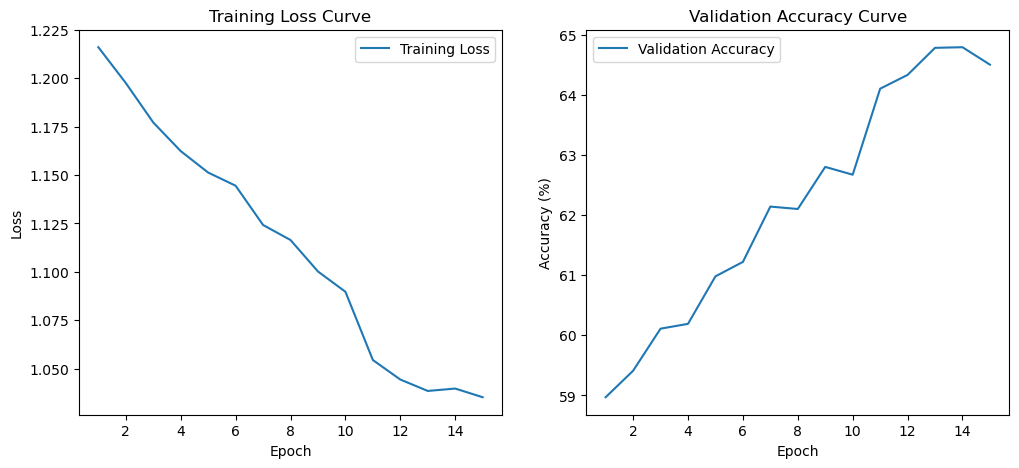

In [41]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_mobilenet_dropout_1, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_mobilenet_dropout_1, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Curve")
plt.legend()

plt.show()

In [45]:
summary(mobilenet_model_dropout1, input_size=(64, 3, 32, 32), device=device)

Layer (type:depth-idx)                                  Output Shape              Param #
MobileNetV2WithDropout                                  [64, 10]                  --
├─MobileNetV2: 1-1                                      [64, 10]                  --
│    └─Sequential: 2-1                                  [64, 1280, 1, 1]          --
│    │    └─Conv2dNormActivation: 3-1                   [64, 32, 16, 16]          928
│    │    └─InvertedResidual: 3-2                       [64, 16, 16, 16]          896
│    │    └─InvertedResidual: 3-3                       [64, 24, 8, 8]            5,136
│    │    └─InvertedResidual: 3-4                       [64, 24, 8, 8]            8,832
│    │    └─InvertedResidual: 3-5                       [64, 32, 4, 4]            10,000
│    │    └─InvertedResidual: 3-6                       [64, 32, 4, 4]            14,848
│    │    └─InvertedResidual: 3-7                       [64, 32, 4, 4]            14,848
│    │    └─InvertedResidual: 3-8       

In [42]:
mobilenet_model_dropout1.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in testloader_aug_mobilenet:
        images, labels = images.to(device).to(torch.float32), labels.to(device)
        outputs = mobilenet_model_dropout1(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy_mobilenet_dropout = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy_mobilenet_dropout:.2f}%")

Test Accuracy: 65.41%


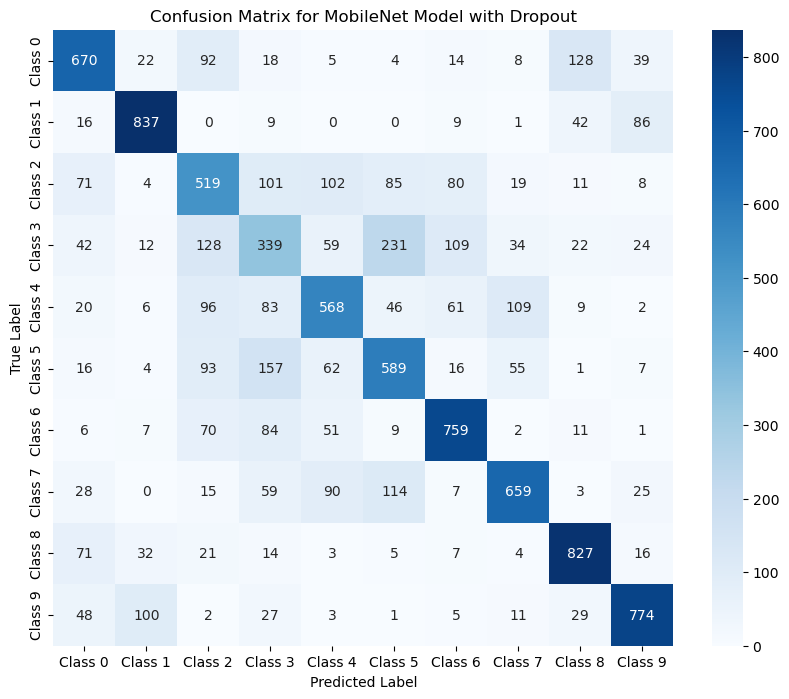

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for MobileNet Model with Dropout")
plt.show()


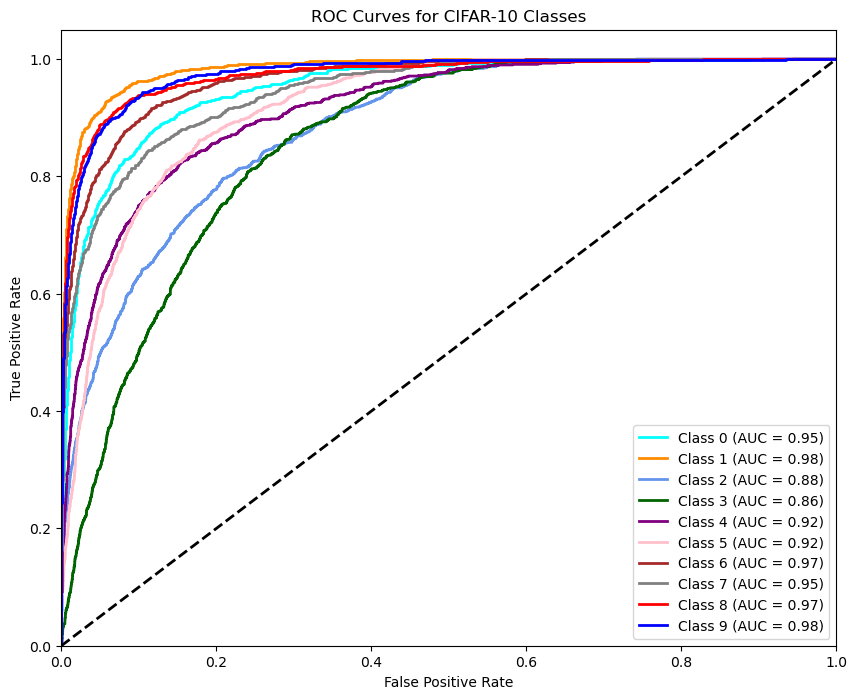

In [43]:
num_classes = 10
y_true = []
y_score = []

mobilenet_model_dropout1.eval()
with torch.no_grad():
    for images, labels in testloader_aug_mobilenet:
        images, labels = images.to(device).to(torch.float32), labels.to(device)
        outputs = mobilenet_model_dropout1(images)
        probs = torch.softmax(outputs, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'purple', 'pink', 'brown', 'grey', 'red', 'blue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CIFAR-10 Classes')
plt.legend(loc="lower right")
plt.show()